In [1]:
import os
import argparse
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
import time
import torchvision.transforms.functional as F
import shutil
from torchvision.models import wide_resnet50_2
from google.colab import drive

****
**BTAD Dataset**


In [ ]:
btad_folder = '/content/drive/MyDrive/BTech_Dataset_transformed'
btad_config_file = os.path.join(btad_folder, 'config')
BTAD_CLASS_NAMES = ['01', '02', '03']
ANOMALY_THRESHOLD = 0

In [ ]:
class BtadDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset class for processing the BTAD dataset.

    Args:
        class_name (str): Class name of the BTAD dataset (e.g., '01', '02', '03').
        resize (int): Size to which the images will be resized.
        cropsize (int): Size for cropping the images after resizing.
        is_train (bool): Specifies whether to load training data (True) or test data (False).
    """
    def __init__(self, class_name, resize=256, cropsize=224, is_train=True):
        self.is_train = is_train
        self.class_name = class_name
        self.resize = resize
        self.cropsize = cropsize

        # 이미지 변환
        self.transform_image = T.Compose([
            T.Resize(resize, Image.LANCZOS), # 이미지 resize
            T.CenterCrop(cropsize),          # 중심 기준으로 이미지 crop
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # 마스크 변환
        self.transform_mask = T.Compose([
            T.Resize(resize, Image.NEAREST),
            T.CenterCrop(cropsize),
            T.ToTensor()
        ])

        self.main_dir = os.path.join(btad_folder, self.class_name, 'train' if self.is_train else 'test')
        self.all_imgs = sorted([f for f in os.listdir(self.main_dir) if os.path.isfile(os.path.join(self.main_dir, f))])
        self.mask_dir = os.path.join(btad_folder, self.class_name, 'ground_truth')
        if not self.is_train:
            self.all_mask = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        """
        Loads an image and its corresponding mask from the dataset based on the given index,
        applies transformations and augmentations, and returns the processed data.

        Args:
            idx (int): Index of the data to retrieve from the dataset.

        Returns:
            image (Tensor): Transformed image tensor.
            defective (int): Defect label (0: normal, 1: defective).
            mask (Tensor): Transformed mask tensor.
        """
        img_path = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_path).convert('RGB')
        mask_path = os.path.join(self.mask_dir, self.all_imgs[idx]) if os.path.isfile(os.path.join(self.mask_dir, self.all_imgs[idx])) else None
        mask = Image.open(mask_path).convert('L') if mask_path else Image.fromarray(np.zeros((self.cropsize, self.cropsize), dtype=np.uint8))

        # train 증강 적용
        if self.is_train:
            if torch.rand(1) < 0.5:
                image = F.hflip(image)
                mask = F.hflip(mask)
            if torch.rand(1) < 0.5:
                image = F.vflip(image)
                mask = F.vflip(mask)
            angle = torch.randint(-15, 15, (1,)).item()
            image = F.rotate(image, angle)
            mask = F.rotate(mask, angle)

        # 일반 변환 적용
        image = self.transform_image(image)
        mask = self.transform_mask(mask)

        # 결함 여부 계산
        defective = 1 if torch.sum(mask) > ANOMALY_THRESHOLD else 0

        return image, defective, mask


In [ ]:
def CreateBtadDataset():
    """
        Prepares the BTAD dataset for use.

        This function performs the following steps:
        1. Checks if the dataset folder exists.
        2. If a configuration file (config) exists, it confirms that the dataset is already prepared.
        3. If the configuration file is missing, it calls `CreateBtadDataset` to prepare the dataset.
    """
    try:
        for Class in BTAD_CLASS_NAMES:
            train_folder = os.path.join(btad_folder, Class, 'train')
            test_folder = os.path.join(btad_folder, Class, 'test')

            # Train 폴더 정리
            train_ok_folder = os.path.join(train_folder, 'ok')
            if os.path.exists(train_ok_folder):
                all_train_imgs = sorted(os.listdir(train_ok_folder))
                for img in all_train_imgs:
                    shutil.move(os.path.join(train_ok_folder, img), train_folder)
                shutil.rmtree(train_ok_folder)

            # Test 폴더 정리
            test_ok_folder = os.path.join(test_folder, 'ok')
            test_ko_folder = os.path.join(test_folder, 'ko')
            if os.path.exists(test_ko_folder):
                for img in sorted(os.listdir(test_ko_folder)):
                    shutil.move(os.path.join(test_ko_folder, img), test_folder)
                shutil.rmtree(test_ko_folder)
            if os.path.exists(test_ok_folder):
                for img in sorted(os.listdir(test_ok_folder)):
                    shutil.move(os.path.join(test_ok_folder, img), test_folder)
                shutil.rmtree(test_ok_folder)

            # Ground truth 정리
            masks_folder = os.path.join(btad_folder, Class, 'ground_truth')
            mask_ko_folder = os.path.join(masks_folder, 'ko')
            if os.path.exists(mask_ko_folder):
                for img in sorted(os.listdir(mask_ko_folder)):
                    shutil.move(os.path.join(mask_ko_folder, img), masks_folder)
                shutil.rmtree(mask_ko_folder)

        # Config 파일 생성
        with open(btad_config_file, "a") as f:
            f.write("Dataset is ready to use.")
        print("Dataset preparation completed.")
    except Exception as e:
        print(f"Error during dataset preparation: {e}")
        shutil.rmtree(btad_folder)
        sys.exit(-1)

def prepareBtad():
    if os.path.isdir(btad_folder):
        if os.path.exists(btad_config_file):
            print("Dataset is already prepared.")
        else:
            print("Preparing the dataset...")
            CreateBtadDataset()
    else:
        print("Dataset folder not found.")
        sys.exit(-1)

prepareBtad()


Dataset is already prepared.


****
**MVTec Dataset**


In [ ]:
CLASS_NAMES = [
    'bottle', 'cable', 'capsule', 'carpet', 'hazelnut', 'leather',
    'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
]

class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, class_name, is_train=True, resize=256, cropsize=224):
        """
        Constructor for the MVTecDataset class.

        Args:
            root_path (str): Path to the root directory of the MVTec dataset.
            class_name (str): Name of the class to process (e.g., 'bottle', 'cable').
            is_train (bool): Specifies whether the dataset is for training (True) or testing (False). Default is True.
            resize (int): The size to which the images will be resized. Default is 256.
            cropsize (int): The size for cropping the images. Default is 224.
        """
        assert class_name in CLASS_NAMES, f'class_name: {class_name}, should be in {CLASS_NAMES}'
        self.root_path = root_path
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.cropsize = cropsize
        self.mvtec_folder_path = os.path.join(root_path)

        self.x, self.y, self.mask = self.load_dataset_folder()

        # 이미지 변환
        self.transform_x = T.Compose([
            T.Resize(resize, Image.LANCZOS),
            T.CenterCrop(cropsize),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # 마스크 변환
        self.transform_mask = T.Compose([
            T.Resize(resize, Image.NEAREST),
            T.CenterCrop(cropsize),
            T.ToTensor()
        ])

    def __getitem__(self, idx):
        x_path, y, mask_path = self.x[idx], self.y[idx], self.mask[idx]

        # 이미지 변환
        x = Image.open(x_path).convert('RGB')
        x = self.transform_x(x)

        # 마스크 변환
        if mask_path is None:  # 정상 이미지
            mask = torch.zeros([1, self.cropsize, self.cropsize])
        else:  # 결함 이미지
            mask = Image.open(mask_path).convert('L')
            mask = self.transform_mask(mask)

        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')

        for img_type in sorted(os.listdir(img_dir)):
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue

            img_fpath_list = sorted([os.path.join(img_type_dir, fname) for fname in os.listdir(img_type_dir) if fname.endswith('.png')])
            x.extend(img_fpath_list)

            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                mask.extend([os.path.join(gt_type_dir, os.path.splitext(fname)[0] + '_mask.png') for fname in os.listdir(img_type_dir)])

        assert len(x) == len(y)
        return x, y, mask


In [ ]:
def parse_args():
    """
    Defined options:
    - `--top_k` (int): Number of top-K nearest neighbors to consider for anomaly score calculation. Default is 5.
    - `--save_path` (str): Path to save the results directory. Default is './result'.
    - `--learning_rate` (float): Learning rate for the model training. Default is 0.1.
    - `--batch_size` (int): Batch size to be used in the data loader. Default is 64.
    """
    parser = argparse.ArgumentParser('Anomaly Detection on BTAD Dataset')
    parser.add_argument("--top_k", type=int, default=5)
    parser.add_argument("--save_path", type=str, default="./result")
    parser.add_argument("--learning_rate", type=float, default=0.1)
    parser.add_argument("--batch_size", type=int, default=64)
    args, unknown = parser.parse_known_args()
    return args


Extracting features: Test 01: 100%|██████████| 3/3 [00:25<00:00,  8.60s/it]


01 ROCAUC: 0.969


Extracting features: Test 02: 100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


02 ROCAUC: 0.768


Extracting features: Test 03: 100%|██████████| 14/14 [01:39<00:00,  7.07s/it]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGEN

03 ROCAUC: 0.998
Average ROCAUC across all classes: 0.911


Extracting features: Test bottle: 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


bottle ROCAUC: 0.987


Extracting features: Test cable: 100%|██████████| 5/5 [00:28<00:00,  5.60s/it]


cable ROCAUC: 0.955


Extracting features: Test capsule: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


capsule ROCAUC: 0.904


Extracting features: Test carpet: 100%|██████████| 4/4 [00:25<00:00,  6.46s/it]


carpet ROCAUC: 0.815


Extracting features: Test hazelnut: 100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


hazelnut ROCAUC: 0.987


Extracting features: Test leather: 100%|██████████| 4/4 [00:25<00:00,  6.46s/it]


leather ROCAUC: 0.957


Extracting features: Test metal_nut: 100%|██████████| 4/4 [00:21<00:00,  5.28s/it]


metal_nut ROCAUC: 0.860


Extracting features: Test pill: 100%|██████████| 6/6 [00:32<00:00,  5.47s/it]


pill ROCAUC: 0.770


Extracting features: Test screw: 100%|██████████| 5/5 [00:29<00:00,  5.94s/it]


screw ROCAUC: 0.766


Extracting features: Test tile: 100%|██████████| 4/4 [00:23<00:00,  5.79s/it]


tile ROCAUC: 0.966


Extracting features: Test toothbrush: 100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


toothbrush ROCAUC: 0.942


Extracting features: Test transistor: 100%|██████████| 4/4 [00:20<00:00,  5.18s/it]


transistor ROCAUC: 0.976


Extracting features: Test wood: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


wood ROCAUC: 0.958


Extracting features: Test zipper: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]


zipper ROCAUC: 0.974
Average ROCAUC across all classes: 0.915


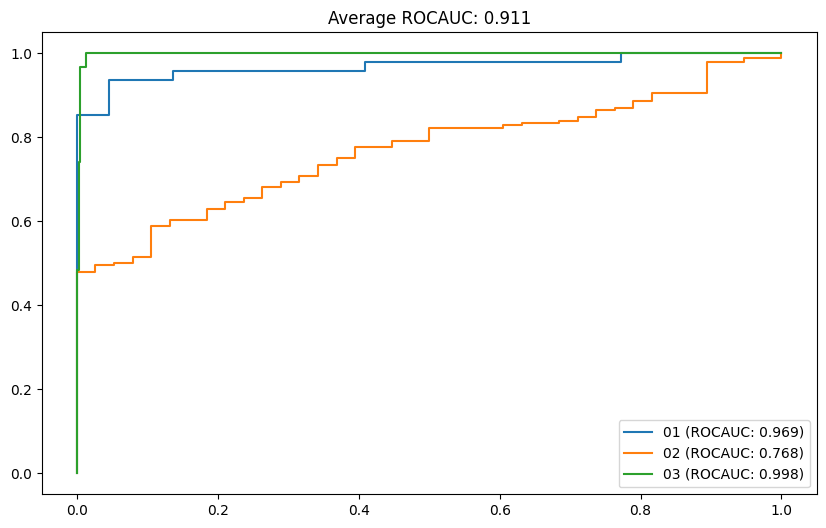

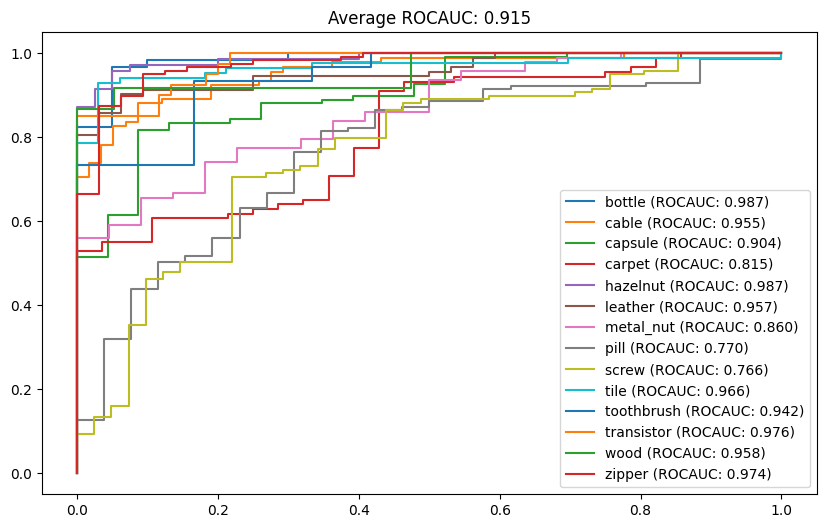

In [ ]:
def main(dataset="BTAD", root_path=None, save_path="./results", batch_size=32, top_k=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 모델 로드
    mobilenet = mobilenet_v2(pretrained=True)
    wideresnet = wide_resnet50_2(pretrained=True)
    mobilenet.to(device).eval()
    wideresnet.to(device).eval()

    # Hook 설정
    mobilenet_outputs, wideresnet_outputs = [], []

    def mobilenet_hook(module, input, output):
        mobilenet_outputs.append(output)

    def wideresnet_hook(module, input, output):
        wideresnet_outputs.append(output)

    mobilenet.features[-1].register_forward_hook(mobilenet_hook)
    wideresnet.avgpool.register_forward_hook(wideresnet_hook)

    os.makedirs(save_path, exist_ok=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    total_roc_auc = []

    # 데이터셋 설정
    if dataset == "BTAD":
        class_names = ['01', '02', '03']
    elif dataset == "MVTec":
        class_names = [
            'bottle', 'cable', 'capsule', 'carpet', 'hazelnut', 'leather',
            'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
        ]
    else:
        raise ValueError("Unsupported dataset. Choose 'BTAD' or 'MVTec'.")

    for class_name in class_names:
        # 데이터셋 로드
        if dataset == "BTAD":
            train_dataset = BtadDataset(class_name=class_name, is_train=True)
            test_dataset = BtadDataset(class_name=class_name, is_train=False)
        elif dataset == "MVTec":
            train_dataset = MVTecDataset(root_path=root_path, class_name=class_name, is_train=True)
            test_dataset = MVTecDataset(root_path=root_path, class_name=class_name, is_train=False)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

        # Train 특징 추출
        mobilenet_train_features, wideresnet_train_features = [], []
        for x, _, _ in tqdm(train_dataloader, desc=f"Extracting features: Train {class_name}"):
            with torch.no_grad():
                mobilenet(x.to(device))
                wideresnet(x.to(device))

            mobilenet_train_features.append(mobilenet_outputs[0].cpu())
            wideresnet_train_features.append(wideresnet_outputs[0].cpu())

            mobilenet_outputs.clear()
            wideresnet_outputs.clear()

        mobilenet_train_features = torch.cat(mobilenet_train_features)
        wideresnet_train_features = torch.cat(wideresnet_train_features)

        # Test 처리
        gt_list, scores_list = [], []
        for x, y, _ in tqdm(test_dataloader, desc=f"Extracting features: Test {class_name}"):
            with torch.no_grad():
                mobilenet(x.to(device))
                wideresnet(x.to(device))

            mobilenet_test_features = mobilenet_outputs[0].cpu()
            wideresnet_test_features = wideresnet_outputs[0].cpu()

            mobilenet_outputs.clear()
            wideresnet_outputs.clear()

            # 거리 계산
            mobilenet_dist_matrix = calc_dist_matrix(torch.flatten(mobilenet_test_features, 1),
                                                     torch.flatten(mobilenet_train_features, 1))
            wideresnet_dist_matrix = calc_dist_matrix(torch.flatten(wideresnet_test_features, 1),
                                                      torch.flatten(wideresnet_train_features, 1))

            # Top-K 평균 거리 계산
            mobilenet_scores = torch.mean(torch.topk(mobilenet_dist_matrix, k=top_k, dim=1, largest=False)[0], 1).numpy()
            wideresnet_scores = torch.mean(torch.topk(wideresnet_dist_matrix, k=top_k, dim=1, largest=False)[0], 1).numpy()

            # 최종 점수
            scores = (mobilenet_scores + wideresnet_scores) / 2

            gt_list.extend(y.cpu().numpy())
            scores_list.extend(scores)

        # ROC AUC
        roc_auc = roc_auc_score(gt_list, scores_list)
        total_roc_auc.append(roc_auc)
        print(f"{class_name} ROCAUC: {roc_auc:.3f}")

        # ROC 곡선
        fpr, tpr, _ = roc_curve(gt_list, scores_list)
        ax.plot(fpr, tpr, label=f'{class_name} (ROCAUC: {roc_auc:.3f})')

    # 평균 ROC AUC
    avg_roc_auc = np.mean(total_roc_auc)
    ax.set_title(f"Average ROCAUC: {avg_roc_auc:.3f}")
    ax.legend(loc="lower right")
    fig.savefig(os.path.join(save_path, f"{dataset}_roc_curve.png"), dpi=100)

    print(f"Average ROCAUC across all classes: {avg_roc_auc:.3f}")

# 거리 계산 함수
def calc_dist_matrix(x, y):
    n, m, d = x.size(0), y.size(0), x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.sqrt(torch.pow(x - y, 2).sum(2))

if __name__ == '__main__':
    main(dataset="BTAD", save_path="./btad_results")
    main(dataset="MVTec", root_path="/content/drive/MyDrive/mvtec", save_path="./mvtec_results")
